In [1]:
import numpy as np

from hfnet.datasets.sfm import Sfm
from hfnet.evaluation.loaders import sift_loader, export_loader
from hfnet.evaluation.utils.descriptors import matching
from hfnet.evaluation.utils.keypoints import keypoints_warp_3D

from utils import plot_matches

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
config = {
    'sequences': ['british_museum', 'london_bridge', 'milan_cathedral','mount_rushmore', 
                  'piazza_san_marco', 'reichstag', 'st_pauls_cathedral',
#                 'florence_cathedral_side', 'lincoln_memorial_statue', 
#                 'united_states_capitol', 'sagrada_familia',
    ],
    'make_pairs': True, 'shuffle': True, 'pair_thresh': 0.4, 'max_num_pairs': 50,
    'preprocessing': {'upright': True}
}
dataset = Sfm(**config)

[03/25/2019 19:40:00 INFO] SfM sequence british_museum contains 50 pairs
[03/25/2019 19:40:10 INFO] SfM sequence london_bridge contains 50 pairs
[03/25/2019 19:40:12 INFO] SfM sequence milan_cathedral contains 50 pairs
[03/25/2019 19:40:13 INFO] SfM sequence mount_rushmore contains 50 pairs
[03/25/2019 19:40:17 INFO] SfM sequence piazza_san_marco contains 50 pairs
[03/25/2019 19:40:18 INFO] No EXIF data for sequence reichstag
[03/25/2019 19:40:18 INFO] SfM sequence reichstag contains 50 pairs
[03/25/2019 19:40:28 INFO] SfM sequence st_pauls_cathedral contains 50 pairs


In [3]:
all_configs = {
    'sift': {
        'predictor': sift_loader,
        'root': True,
    },
    'superpoint': {
        'experiment': 'super_point_pytorch/sfm_upright',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
        'binarize': False,
    },
    'doap': {
        'experiment': 'doap/sfm_upright_hpatches_ST-dense',
        'predictor': export_loader,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/sfm_upright',
            'do_nms': True,
            'nms_thresh': 4,
            'remove_borders': 4,
        },
        'binarize': False,
    },  
    'netvlad_conv3-3': {
        'experiment': 'netvlad/sfm_upright',
        'predictor': export_loader,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/sfm_upright',
            'do_nms': True,
            'nms_thresh': 4,
            'remove_borders': 4,
        },
        'binarize': False,
    },
    'lfnet': {
        'experiment': 'lfnet/sfm_upright_kpts-1000',
        'predictor': export_loader,
    },
    'hfnet': {
        'experiment': 'hfnet-shared_weights-unc_aug-photo_glm-bdd_lrsteps/sfm',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
    },
}
eval_config = {'num_features': 1000}
configs = {c: {**all_configs[c], **eval_config} for c in ['sift', 'superpoint', 'hfnet']}

In [4]:
def compute_matching_score_single(kpts_w, kpts, matches, vis_w, dist_thresh=5):
    vis_matched = vis_w[matches[:, 0]]
    match_dist = np.linalg.norm(kpts_w[matches[:, 0]] - kpts[matches[:, 1]], axis=-1)
    correct_matches = ((match_dist < dist_thresh)*vis_matched).sum()
    match_score = correct_matches / np.maximum(np.sum(vis_w), 1.0)
    assert vis_matched.sum() == vis_w.sum()
    return match_score, vis_matched.sum(), correct_matches, (match_dist < dist_thresh)

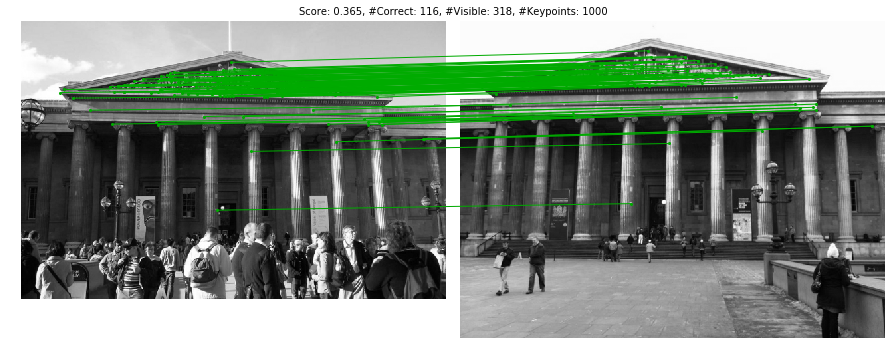

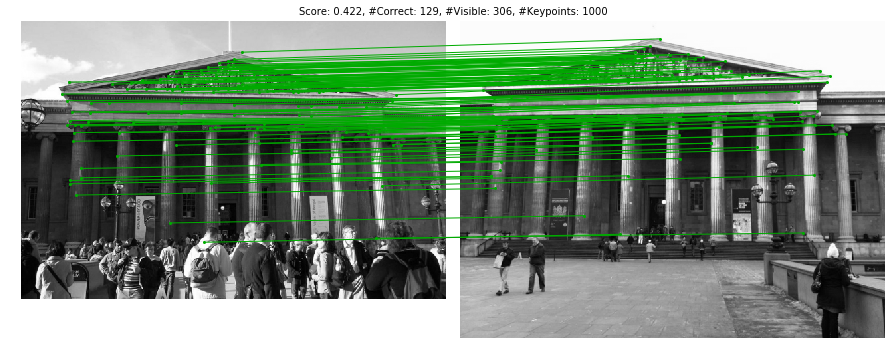

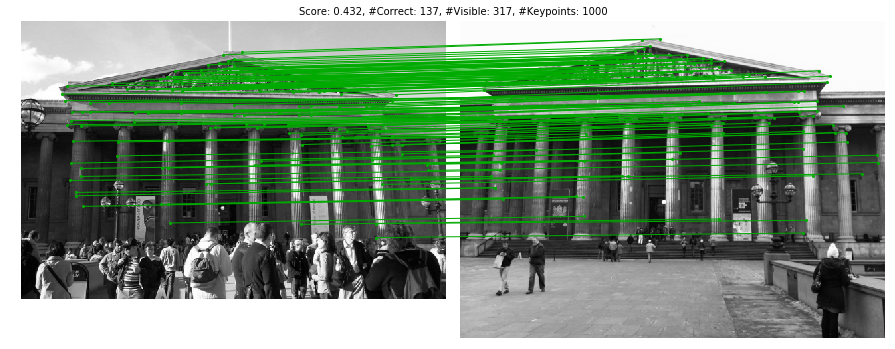

In [6]:
data_iter = dataset.get_test_set()
for _, data in zip(range(1), data_iter):
    for method, config in configs.items():
        pred1 = config['predictor'](data['image'], data['name'], **config)
        pred2 = config['predictor'](data['image2'], data['name2'], **config)

        all_matches, matches_dist = matching(
            pred1['descriptors'], pred2['descriptors'],
            do_ratio_test=False, cross_check=False)
              
        kpts1_w, vis1, kpts1_3d_1 = keypoints_warp_3D(
            pred1['keypoints'], data['depth'], data['K'], data['K2'],
            np.linalg.inv(data['1_T_2']), data['image2'].shape[1::-1],
            depth2=data['depth2'], consistency_check=True)
        kpts2_w, vis2, kpts2_3d_2 = keypoints_warp_3D(
            pred2['keypoints'], data['depth2'], data['K2'],
            data['K'], data['1_T_2'], data['image'].shape[1::-1],
            depth2=data['depth'], consistency_check=True)
        
        ms, vis_m, cm, good = compute_matching_score_single(kpts1_w, pred2['keypoints'], all_matches, vis1)
        matches = all_matches[good]
        
        plot_matches(
            data['image'].astype(np.uint8), pred1['keypoints'],
            data['image2'], pred2['keypoints'], matches, color=(0, 0.67, 0),
            dpi=150, ylabel=method, thickness=1.,
            title=f'Score: {ms:.3f}, #Correct: {cm}, #Visible: {vis_m}, #Keypoints: {len(kpts1_w)}')
        continue
        
        plot_images(
            [draw_matches(data['image'].astype(np.uint8), pred1['keypoints'],
                          data['image2'].astype(np.uint8), pred2['keypoints'],
                          matches, thickness=1, kp_radius=3, color=(0, 170, 0))],
            title=[f'Score: {ms:.3f}, #Correct: {cm}, #Visible: {vis_m}, #Keypoints: {len(kpts1_w)}'],
            ylabel=method, labelfont=12, titlefont=8,
            dpi=200)